In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

from datetime import datetime

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv
deaths = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
land = pd.read_excel('data/LND01.xls') #https://www2.census.gov/prod2/statcomp/usac/excel/LND01.xls
elections = pd.read_csv('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv')

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [3]:
vaccinations = vaccinations.fillna(0)
cases = cases.fillna(value = {'FIPS': 0, 'Admin2': ''})
deaths = deaths.fillna(0)

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [5]:
def get_fips(state_num, county_num):
    fips_arr = np.array([])
    for i in np.arange(0,len(state_num)):
        fips_state = str(state_num[i])
        if 0 <= county_num[i] < 10:
            fips_county = "00" + str(county_num[i])
        elif 10 <= county_num[i] < 100:
            fips_county = "0" + str(county_num[i])
        else:
            fips_county = str(county_num[i])
        fips_arr = np.append(fips_arr, int(fips_state + fips_county))
    return fips_arr

counties['FIPS'] = get_fips(counties['STATE'], counties['COUNTY'])

In [6]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [7]:
county_data = pd.merge(counties, cases, on = 'FIPS')
county_data = pd.merge(county_data, mask_use, left_on = 'FIPS', right_on = 'COUNTYFP')
county_data.head()

SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME         CTYNAME  \
0      50       3         6      1       1  Alabama  Autauga County   
1      50       3         6      1       3  Alabama  Baldwin County   
2      50       3         6      1       5  Alabama  Barbour County   
3      50       3         6      1       7  Alabama     Bibb County   
4      50       3         6      1       9  Alabama   Blount County   

  CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  ...  9/9/21  9/10/21  \
0         54571              54582            54761  ...    9145     9207   
1        182265             182263           183121  ...   34536    34726   
2         27457              27454            27325  ...    3243     3260   
3         22915              22904            22858  ...    3727     3752   
4         57322              57322            57372  ...    9048     9095   

   9/11/21  9/12/21  COUNTYFP  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS  
0     9246     9287      1001  0.053   0.074      0.134       0.295   0.444  
1    34872    34950      1003  0.083   0.059      0.098       0.323   0.436  
2     3282     3295      1005  0.067   0.121      0.120       0.201   0.491  
3     3778     3795      1007  0.020   0.034      0.096       0.278   0.572  
4     9161     9176      1009  0.053   0.114      0.180       0.194   0.459  

[5 rows x 638 columns]

In [8]:
grader.check("q1e")

q1e results: All test cases passed!

# Further Data Cleaning

In [9]:
from datetime import datetime
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [10]:
# county_data dataframe with only counties in the contiguous US.
contiguous_us = county_data[(county_data['STATE'] != 2)][(county_data['STATE'] != 15)][(county_data['STATE'] != 60)][(county_data['STATE'] != 69)][(county_data['STATE'] != 66)][(county_data['STATE'] != 72)][(county_data['STATE'] != 78)]

# list of indicies in the contiguous US.
FIPS_indices = contiguous_us['FIPS'].sort_values().tolist()
state_indices = contiguous_us['STATE'].sort_values().tolist()

In [11]:
# dataframe with county population indexed by fips
county_pops_by_fips = counties[counties['COUNTY'] != 0][counties['FIPS'].isin(FIPS_indices)][['FIPS', 'POPESTIMATE2020']].set_index('FIPS')
# dataframe with state population indexed by fips
state_pops_by_fips = counties[counties['COUNTY'] == 0][counties['STATE'].isin(state_indices)][['STATE', 'POPESTIMATE2020']].set_index('STATE')


In [12]:
# data frame with the county size (in square miles) and FIPS codes
land = pd.read_excel('data/LND01.xls')
land = land[['STCOU', 'LND210200D']].rename({'STCOU': 'FIPS', 'LND210200D': 'squared miles'}, axis=1)
land = land[land['FIPS'].isin(FIPS_indices)]
land.head()

FIPS  squared miles
2  1001           8.48
3  1003         430.58
4  1005          19.61
5  1007           3.14
6  1009           5.02

In [13]:
# dataframe merging county_data and land
all_data = pd.merge(county_data, land, on = 'FIPS')
# creates a population density column by using the 2020 population estimate and the county size
all_data['population density'] = all_data['POPESTIMATE2020']/all_data['squared miles']
# sets infinite values to 0
with pd.option_context('mode.use_inf_as_na', True):
    all_data = all_data.fillna(0)
all_data.head()

SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME         CTYNAME  \
0      50       3         6      1       1  Alabama  Autauga County   
1      50       3         6      1       3  Alabama  Baldwin County   
2      50       3         6      1       5  Alabama  Barbour County   
3      50       3         6      1       7  Alabama     Bibb County   
4      50       3         6      1       9  Alabama   Blount County   

  CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  ...  9/11/21  9/12/21  \
0         54571              54582            54761  ...     9246     9287   
1        182265             182263           183121  ...    34872    34950   
2         27457              27454            27325  ...     3282     3295   
3         22915              22904            22858  ...     3778     3795   
4         57322              57322            57372  ...     9161     9176   

   COUNTYFP  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS  squared miles  \
0      1001  0.053   0.074      0.134       0.295   0.444           8.48   
1      1003  0.083   0.059      0.098       0.323   0.436         430.58   
2      1005  0.067   0.121      0.120       0.201   0.491          19.61   
3      1007  0.020   0.034      0.096       0.278   0.572           3.14   
4      1009  0.053   0.114      0.180       0.194   0.459           5.02   

   population density  
0         6620.872642  
1          532.507316  
2         1253.901071  
3         7049.681529  
4        11529.681275  

[5 rows x 640 columns]

In [14]:
# creates a data frame with the per capita of total covid in each county by date (indexed by fips)
cases_by_fips = cases[cases['FIPS'].isin(FIPS_indices)].set_index('FIPS').iloc[:, 336:]
cases_by_fips = pd.merge(cases_by_fips, county_pops_by_fips, on = 'FIPS')
for col in cases_by_fips.columns.tolist():
    cases_by_fips[col] = cases_by_fips[col]/cases_by_fips['POPESTIMATE2020']
cases_by_fips = cases_by_fips.drop(columns = ['POPESTIMATE2020'])
dates = cases_dates = cases_by_fips.columns 
dts = list(map(lambda x: datetime.strptime(x, '%m/%d/%y').date(), dates))
cases_by_fips = cases_by_fips.set_axis(dts, axis=1)
cases_by_fips.head()

2020-12-13  2020-12-14  2020-12-15  2020-12-16  2020-12-17  \
FIPS                                                                 
1001.0    0.058776    0.059293    0.061021    0.062517    0.063585   
1003.0    0.047129    0.047530    0.048241    0.048899    0.049562   
1005.0    0.051730    0.051852    0.052544    0.052706    0.053235   
1007.0    0.065098    0.065730    0.067944    0.068666    0.069931   
1009.0    0.065240    0.065706    0.067054    0.068246    0.069732   

        2020-12-18  2020-12-19  2020-12-20  2020-12-21  2020-12-22  ...  \
FIPS                                                                ...   
1001.0    0.064957    0.065865    0.066631    0.067326    0.068412  ...   
1003.0    0.050400    0.051124    0.051582    0.052127    0.053012  ...   
1005.0    0.053601    0.054089    0.054333    0.054333    0.055431  ...   
1007.0    0.071241    0.072326    0.072868    0.073545    0.074991  ...   
1009.0    0.071148    0.072410    0.072876    0.073153    0.074518  ...   

        2021-09-03  2021-09-04  2021-09-05  2021-09-06  2021-09-07  \
FIPS                                                                 
1001.0    0.158678    0.159569    0.160513    0.161154    0.161421   
1003.0    0.147366    0.148146    0.148561    0.148905    0.149359   
1005.0    0.127781    0.128757    0.129489    0.130017    0.130424   
1007.0    0.161728    0.163444    0.163896    0.164483    0.165387   
1009.0    0.151402    0.152560    0.153113    0.153752    0.154650   

        2021-09-08  2021-09-09  2021-09-10  2021-09-11  2021-09-12  
FIPS                                                                
1001.0    0.162223    0.162882    0.163986    0.164681    0.165411  
1003.0    0.150000    0.150623    0.151452    0.152089    0.152429  
1005.0    0.131156    0.131888    0.132580    0.133474    0.134003  
1007.0    0.166877    0.168368    0.169498    0.170672    0.171440  
1009.0    0.155462    0.156326    0.157138    0.158278    0.158538  

[5 rows x 274 columns]

In [15]:
# creates a data frame with the current proportion of vaccinated people in each state by date (indexed by fips)
vaxx_by_fips = vaccinations[vaccinations['FIPS'].isin(state_indices)]
vaxx_by_fips = pd.merge(vaxx_by_fips, state_pops_by_fips, left_on = 'FIPS', right_on = 'STATE')
vaxx_by_fips['Prop_Fully_Vaccinated'] = vaxx_by_fips['People_Fully_Vaccinated']/vaxx_by_fips['POPESTIMATE2020']
vaxx_by_fips = vaxx_by_fips.pivot_table(values = 'Prop_Fully_Vaccinated', index = 'FIPS', columns = 'Date', aggfunc = sum)
vaxx_by_fips = vaxx_by_fips.iloc[:, 3:277]
vaxx_by_fips = vaxx_by_fips.set_axis(dts, axis=1)
vaxx_by_fips.head()


2020-12-13  2020-12-14  2020-12-15  2020-12-16  2020-12-17  2020-12-18  \
FIPS                                                                           
1.0          0.0         0.0         0.0         0.0         0.0         0.0   
4.0          0.0         0.0         0.0         0.0         0.0         0.0   
5.0          0.0         0.0         0.0         0.0         0.0         0.0   
6.0          0.0         0.0         0.0         0.0         0.0         0.0   
8.0          0.0         0.0         0.0         0.0         0.0         0.0   

      2020-12-19  2020-12-20  2020-12-21  2020-12-22  ...  2021-09-03  \
FIPS                                                  ...               
1.0          0.0         0.0         0.0         0.0  ...    0.386237   
4.0          0.0         0.0         0.0         0.0  ...    0.479919   
5.0          0.0         0.0         0.0         0.0  ...    0.420601   
6.0          0.0         0.0         0.0         0.0  ...    0.577094   
8.0          0.0         0.0         0.0         0.0  ...    0.575376   

      2021-09-04  2021-09-05  2021-09-06  2021-09-07  2021-09-08  2021-09-09  \
FIPS                                                                           
1.0     0.389251    0.389251    0.389251    0.392173    0.393793    0.394195   
4.0     0.480823    0.481132    0.481682    0.483191    0.483601    0.484101   
5.0     0.422969    0.422969    0.422969    0.426844    0.427386    0.428983   
6.0     0.578222    0.579437    0.579987    0.580371    0.581370    0.582828   
8.0     0.576485    0.577223    0.577677    0.578026    0.578769    0.579795   

      2021-09-10  2021-09-11  2021-09-12  
FIPS                                      
1.0     0.397612    0.398147    0.400493  
4.0     0.485193    0.486160    0.487078  
5.0     0.431606    0.433264    0.435045  
6.0     0.584162    0.585461    0.586602  
8.0     0.580695    0.581683    0.582551  

[5 rows x 274 columns]

In [16]:
# creates a dataframe where total deaths are indexed by county fips
deaths_by_fips = deaths[deaths['fips'].isin(FIPS_indices)]
deaths_by_fips = pd.merge(deaths_by_fips, county_pops_by_fips, left_on = 'fips', right_on = 'FIPS')
deaths_by_fips['deaths'] = deaths_by_fips['deaths']/deaths_by_fips['POPESTIMATE2020']
deaths_by_fips = deaths_by_fips.pivot_table(values = 'deaths', index = 'fips', columns = 'date', aggfunc = sum)
deaths_by_fips = deaths_by_fips.fillna(0).iloc[:,327:601]
deaths_by_fips = deaths_by_fips.set_axis(dts, axis=1)
deaths_by_fips = deaths_by_fips.rename_axis('FIPS', axis =0)
deaths_by_fips.head()

2020-12-13  2020-12-14  2020-12-15  2020-12-16  2020-12-17  \
FIPS                                                                 
1001.0    0.000730    0.000730    0.000766    0.000766    0.000766   
1003.0    0.000615    0.000615    0.000615    0.000632    0.000632   
1005.0    0.001220    0.001220    0.001220    0.001220    0.001220   
1007.0    0.001807    0.001807    0.001762    0.001897    0.001897   
1009.0    0.000812    0.000812    0.000847    0.000864    0.000898   

        2020-12-18  2020-12-19  2020-12-20  2020-12-21  2020-12-22  ...  \
FIPS                                                                ...   
1001.0    0.000784    0.000784    0.000784    0.000784    0.000784  ...   
1003.0    0.000637    0.000641    0.000641    0.000641    0.000650  ...   
1005.0    0.001220    0.001301    0.001301    0.001301    0.001301  ...   
1007.0    0.001897    0.001897    0.001897    0.001897    0.001897  ...   
1009.0    0.000898    0.000933    0.000933    0.000933    0.000933  ...   

        2021-09-03  2021-09-04  2021-09-05  2021-09-06  2021-09-07  \
FIPS                                                                 
1001.0    0.002120    0.002120    0.002120    0.002120    0.002120   
1003.0    0.001710    0.001710    0.001710    0.001710    0.001710   
1005.0    0.002643    0.002643    0.002643    0.002643    0.002643   
1007.0    0.003343    0.003343    0.003343    0.003343    0.003343   
1009.0    0.002523    0.002523    0.002523    0.002523    0.002523   

        2021-09-08  2021-09-09  2021-09-10  2021-09-11  2021-09-12  
FIPS                                                                
1001.0    0.002120    0.002120    0.002120    0.002120    0.002120  
1003.0    0.001745    0.001753    0.001793    0.001797    0.001797  
1005.0    0.002643    0.002643    0.002725    0.002725    0.002725  
1007.0    0.003343    0.003343    0.003343    0.003388    0.003388  
1009.0    0.002540    0.002540    0.002523    0.002523    0.002523  

[5 rows x 274 columns]

In [17]:
# creates a new data frame containing the NEW daily covid cases in each county
new_cases = cases_by_fips.copy() # starts as a copy of the cases_by_fips df
# for each column, starting from the last column and going to the second column, set the current column equal to the current column minus the column before it
for i in np.arange(len(new_cases.columns)-1, 0, -1):
    col_name = new_cases.columns[i]
    col_name_prev = new_cases.columns[i-1]
    new_cases[col_name] = new_cases[col_name]-new_cases[col_name_prev]
# if there are any negative values, set them equal to 0
new_cases[new_cases<0] = 0

# list of the dates we are using in our weekly model
weekly_dates = vaxx_by_fips.columns[1::7].tolist() # the period of time studied is between 2020-12-13 and 2021-09-12, and are measured in weekly intervals of 7 days. 

# creates a new data frame containing the NEW weekly covid cases in each county
new_cases_weekly = cases_by_fips.loc[:, weekly_dates] # starts as a copy of the cases_by_fips df with only one column representing a week
# for each column, starting from the last column and going to the second column, set the current column equal to the current column minus the column before it
for i in np.arange(len(new_cases_weekly.columns)-1, 0, -1):
    col_name = new_cases_weekly.columns[i]
    col_name_prev = new_cases_weekly.columns[i-1]
    new_cases_weekly[col_name] = new_cases_weekly[col_name]-new_cases_weekly[col_name_prev]
# if there are any negative values, set them equal to 0
new_cases_weekly[new_cases<0] = 0

#setting name attributes for each dataframe
new_cases_weekly.name = "new cases weekly"
new_cases.name = "new cases daily"

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

Text(0.5, 1.0, 'Pairwise Correlation between mask_use columns and 9/12/21 COVID-19 cases')

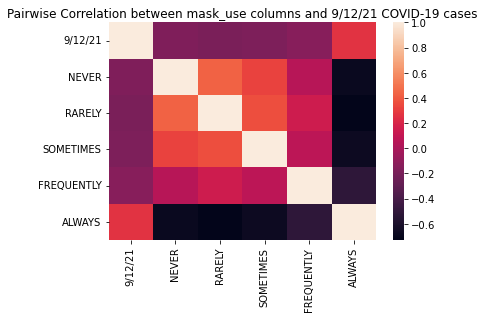

In [18]:
pairwise_corrs = county_data[['9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']].corr()

sns.heatmap(pairwise_corrs)
plt.title('Pairwise Correlation between mask_use columns and 9/12/21 COVID-19 cases')

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [19]:
import sklearn

def rmse(y, y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))

X_q5b = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5b = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = sklearn.model_selection.train_test_split(X_q5b, y_q5b, test_size=.33, random_state=42)

model_5b = sklearn.linear_model.LinearRegression()
model_5b.fit(X_q5b_train, y_q5b_train)
train_rmse_cases = rmse(y_q5b_train, model_5b.predict(X_q5b_train))
test_rmse_cases = rmse(y_q5b_test, model_5b.predict(X_q5b_test))
train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [20]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

_A potential reason for the test set RMSE being much higher compared to the training set RMSE is that we our model is predicting number of cases, not cases per capita. This poses issues because each county has different population sizes. Another reason for test set RMSE being much higher than training set RMSE could be overfitting data._

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [21]:
X_q5d = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5d = county_data['9/12/21']/county_data['POPESTIMATE2020']
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = sklearn.model_selection.train_test_split(X_q5d, y_q5d, test_size=.33, random_state=42)

model_5d = sklearn.linear_model.LinearRegression()
model_5d.fit(X_q5d_train, y_q5d_train)
train_rmse_cpc = rmse(y_q5d_train, model_5d.predict(X_q5d_train))
test_rmse_cpc = rmse(y_q5d_test, model_5d.predict(X_q5d_test))

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038167903498916037)

In [22]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

Text(0.5, 1.0, 'predicted vs. observed COVID-19 cases per capita')

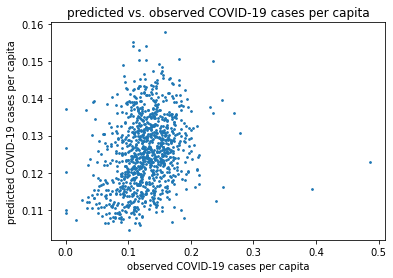

In [23]:
plt.scatter(y_q5d_test, model_5d.predict(X_q5d_test), s=3)
plt.ylabel('predicted COVID-19 cases per capita')
plt.xlabel('observed COVID-19 cases per capita')
plt.title('predicted vs. observed COVID-19 cases per capita')
# This plot indicates a somewhat strong correlation between the predicted and observed 
# COVID-19 cases per capita within the test set

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [24]:
models = []
for i in np.arange(1000):
    curr_model = sklearn.linear_model.LinearRegression()
    bootstrapped_X = X_q5d_train.sample(n=X_q5d_train.shape[0], replace=True, random_state=42)
    bootstrapped_y = y_q5d_train.loc[bootstrapped_X.index.to_list()]
    curr_model.fit(bootstrapped_X, bootstrapped_y)
    models += [curr_model]

In [25]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [26]:
preds = []
squared_errors = []

for i in np.arange(1000):
    model = models[i]
    y_hat = model.predict([X_q5d_test.loc[100]])[0]
    preds += [y_hat]
    squared_errors += [(y_q5d_test.iloc[100] - y_hat) ** 2]

prop_var = np.var(preds) / np.mean(squared_errors)
prop_var

1.4918754246737842e-30

In [27]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

_

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [28]:
variances = []
expectations_squared_errors = []

for j in np.arange(X_q5d_test.shape[0]): 
    thousand_j_preds = []
    for i in np.arange(1000):
        curr_model = models[i]
        y_hat = curr_model.predict([X_q5d_test.iloc[j]])[0]
        thousand_j_preds += [y_hat]
    expectations_squared_errors += [np.average((y_q5d_test.iloc[j] - thousand_j_preds) ** 2)]
    variances += [(preds - np.mean(preds)) / (len(preds) - 1)]

avg_var, avg_mse = np.average(variances), np.average(expectations_squared_errors)
avg_var, avg_mse

(-5.556671794920714e-20, 0.0014582905853461686)

In [29]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

A solution to reducing mean square error would be to implement regularization. We have estimated bias (assuming no noise), variance, and expected SE of the 100th point in 5g/h. We have also estimated variance and MSE in 5i. We can conclude that observational variance from 5i is low and observational bias from 5i is also low.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

In [30]:
states_to_pred = all_data[all_data['STNAME'] != 'District of Columbia'][all_data['COUNTYFP'].isin(FIPS_indices)]['STNAME'].unique() #list of states to run our model on


In [31]:
# create df with state names and their abbreviations
us_state_to_abbrev = {"Alabama": "AL", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", 
                        "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA",
                        "Kansas": "KS","Kentucky": "KY","Louisiana": "LA","Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", 
                        "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", 
                        "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", 
                        "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", 
                        "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"}
state_to_abbrev = pd.DataFrame(us_state_to_abbrev, index = ['abbrev']).transpose().reset_index().rename({'index': 'STNAME'}, axis = 1) 


<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [32]:
# helper function to use on each county for state in function_6a
def function_6a_df(county):
    new_cases_for_county = new_cases.transpose()[county].to_numpy()
    dt = new_cases.transpose().index
    df_6a = pd.DataFrame({'dates': dt, 'county new cases': new_cases_for_county}).set_index('dates')
    df_6a['yesterday cases'] = df_6a['county new cases'].shift()
    df_6a = df_6a.dropna()
    return df_6a.loc[weekly_dates, :]


In [34]:
# function that creates model where we use the previous days covid cases to predict todays covid cases for a given county and returns the rmse
def function_6a_rmse_model(state): 
    test_pred = []
    test_actual = []
    
    train_pred = []
    train_actual = []
    
    counties_in_state = all_data[all_data['STNAME'] == state]['FIPS'].unique()

    for county in counties_in_state:
        X_q6a = function_6a_df(county)[['yesterday cases']]
        y_q6a = function_6a_df(county)['county new cases']

        X_q6a_train, X_q6a_test, y_q6a_train, y_q6a_test = sklearn.model_selection.train_test_split(X_q6a, y_q6a, test_size=.33, random_state=42)

        model_6a = sklearn.linear_model.LinearRegression()
        model_6a.fit(X_q6a_train, y_q6a_train)
    
        test_pred += [np.mean(model_6a.predict(X_q6a_test))]
        test_actual += [np.mean(y_q6a_test)]
        
        test_pred = np.array(test_pred)
        test_actual = np.array(test_actual)
        
        train_pred += [np.mean(model_6a.predict(X_q6a_train))]
        train_actual += [np.mean(y_q6a_train)]
        
        train_pred = np.array(train_pred)
        train_actual = np.array(train_actual)
        
    return rmse(train_pred, train_actual), rmse(test_pred, test_actual)

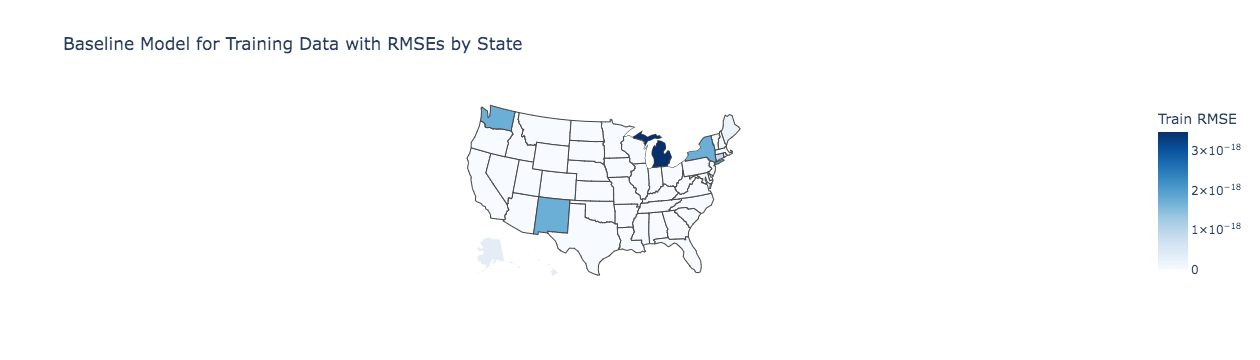

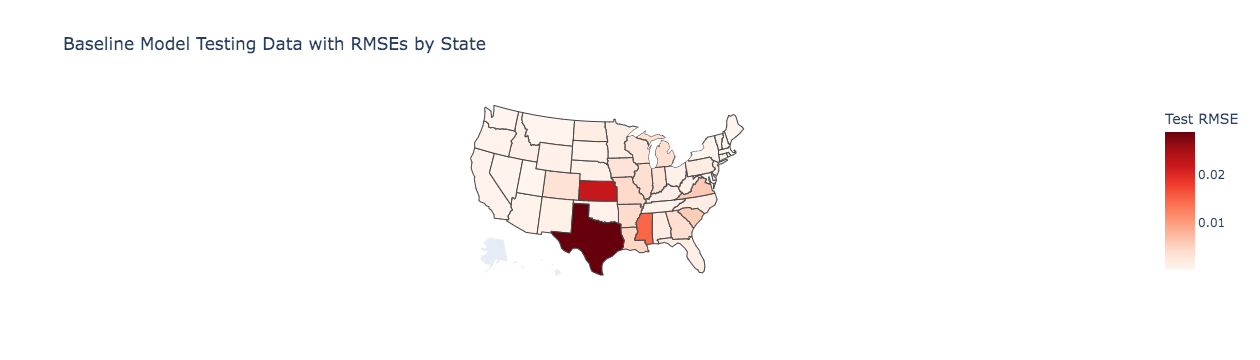

In [35]:
def plotting_6a():
    # runs function_6a_rmse_model() for all states 
    all_states_6a_rmse_model = {}
    for state in states_to_pred:
        all_states_6a_rmse_model[state] = function_6a_rmse_model(state)
    
    # create df with the rmse results from our model
    model_6a_df = pd.DataFrame(all_states_6a_rmse_model).transpose().reset_index()
    model_6a_df = model_6a_df.rename({'index': 'STNAME', 0: 'Train RMSE', 1: 'Test RMSE'}, axis=1)
    # merge rmse results with abbreviations to help with plotting
    model_6a_df = model_6a_df.merge(state_to_abbrev, on = 'STNAME')
    
    # plot for training rmse
    fig = go.Figure(data=go.Choropleth(
        locations = model_6a_df['abbrev'], # Spatial coordinates
        z = model_6a_df['Train RMSE'], # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Blues',
        colorbar_title = "Train RMSE",
    ))
    fig.update_layout(
        title_text = 'Baseline Model for Training Data with RMSEs by State',
        geo_scope='usa', # limite map scope to USA
    )
    fig.show()
    
    # plot for test rmse
    fig = go.Figure(data=go.Choropleth(
        locations = model_6a_df['abbrev'], # Spatial coordinates
        z = model_6a_df['Test RMSE'], # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Reds',
        colorbar_title = "Test RMSE",
    ))
    fig.update_layout(
        title_text = 'Baseline Model Testing Data with RMSEs by State',
        geo_scope='usa', # limite map scope to USA
    )
    fig.show()

plotting_6a()

In [36]:
all_states_6a_rmse_model = {}
for state in all_data.sort_values('STNAME')['STNAME'].unique():
    all_states_6a_rmse_model[state] = function_6a_rmse_model(state)


In [37]:
baseline_training_rmse = []
baseline_testing_rmse = []
for rmse_tuple in all_states_6a_rmse_model.values(): 
    train_rmse_val, test_rmse_val = rmse_tuple 
    baseline_training_rmse += [train_rmse_val] 
    baseline_testing_rmse += [test_rmse_val] 
print("average training rmse: ", np.average(baseline_training_rmse))
print("min training rmse: ", min(baseline_training_rmse))
print("max training rmse: ", max(baseline_training_rmse))
print("")
print("average testing rmse: ", np.average(baseline_testing_rmse))
print("min testing rmse: ", min(baseline_testing_rmse))
print("max testing rmse: ", max(baseline_testing_rmse))

average training rmse:  1.9913917453815388e-19
min training rmse:  0.0
max training rmse:  3.469446951953614e-18

average testing rmse:  0.0027623725127868923
min testing rmse:  1.585592234595965e-05
max testing rmse:  0.029029052248454066


In [40]:
model_6a_df = pd.DataFrame(all_states_6a_rmse_model).transpose().reset_index()
model_6a_df = model_6a_df.rename({'index': 'STNAME', 0: 'Train RMSE', 1: 'Test RMSE'}, axis=1)
model_6a_df = model_6a_df.merge(state_to_abbrev, on = 'STNAME')
model_6a_df

STNAME    Train RMSE  Test RMSE abbrev
0          Alabama  0.000000e+00   0.001831     AL
1          Arizona  0.000000e+00   0.000589     AZ
2         Arkansas  0.000000e+00   0.003993     AR
3       California  0.000000e+00   0.000558     CA
4         Colorado  0.000000e+00   0.003250     CO
5      Connecticut  8.673617e-19   0.000614     CT
6         Delaware  0.000000e+00   0.000060     DE
7          Florida  0.000000e+00   0.001098     FL
8          Georgia  0.000000e+00   0.003699     GA
9            Idaho  0.000000e+00   0.001013     ID
10        Illinois  0.000000e+00   0.003683     IL
11         Indiana  0.000000e+00   0.003130     IN
12            Iowa  0.000000e+00   0.002969     IA
13          Kansas  0.000000e+00   0.022238     KS
14        Kentucky  0.000000e+00   0.001166     KY
15       Louisiana  0.000000e+00   0.004553     LA
16           Maine  2.168404e-19   0.000021     ME
17        Maryland  0.000000e+00   0.000044     MD
18   Massachusetts  0.000000e+00   0.000301     MA
19        Michigan  3.469447e-18   0.003775     MI
20       Minnesota  0.000000e+00   0.001275     MN
21     Mississippi  0.000000e+00   0.014753     MS
22        Missouri  0.000000e+00   0.004211     MO
23         Montana  0.000000e+00   0.000273     MT
24        Nebraska  0.000000e+00   0.000942     NE
25          Nevada  0.000000e+00   0.000396     NV
26   New Hampshire  0.000000e+00   0.000048     NH
27      New Jersey  0.000000e+00   0.000918     NJ
28      New Mexico  1.734723e-18   0.000964     NM
29        New York  1.734723e-18   0.000261     NY
30  North Carolina  0.000000e+00   0.001343     NC
31    North Dakota  0.000000e+00   0.001478     ND
32            Ohio  0.000000e+00   0.000858     OH
33        Oklahoma  0.000000e+00   0.000542     OK
34          Oregon  0.000000e+00   0.000592     OR
35    Pennsylvania  0.000000e+00   0.001574     PA
36    Rhode Island  0.000000e+00   0.000234     RI
37  South Carolina  0.000000e+00   0.005556     SC
38    South Dakota  0.000000e+00   0.000488     SD
39       Tennessee  0.000000e+00   0.000587     TN
40           Texas  0.000000e+00   0.029029     TX
41            Utah  0.000000e+00   0.000085     UT
42         Vermont  0.000000e+00   0.000130     VT
43        Virginia  0.000000e+00   0.005858     VA
44      Washington  1.734723e-18   0.000142     WA
45   West Virginia  0.000000e+00   0.000965     WV
46       Wisconsin  0.000000e+00   0.002347     WI
47         Wyoming  0.000000e+00   0.000904     WY

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [38]:
def make_features_df(week):
    
    #select voter data
    votes_by_fips = elections.set_index('county_fips').loc[:, ['per_gop']]

    #select death data 
    death_toll_by_fips = pd.DataFrame(deaths_by_fips[week])

    #select weekly vaxx data
    curr_vaxx_by_fips = pd.DataFrame(vaxx_by_fips[week]) # indexed by state

    #join weekly case, death, and vaxx data with relevant county demographic information 
    relevant_cols = all_data[['STATE', 'STNAME','POPESTIMATE2020', 'COUNTYFP', 'ALWAYS', 'population density']]

    #merging X_train table: 
    df = relevant_cols.merge(votes_by_fips, left_on='COUNTYFP', right_on='county_fips') 
    df = df.merge(death_toll_by_fips, left_on='COUNTYFP', right_on='FIPS')
    df = df.merge(curr_vaxx_by_fips, left_on='STATE', right_on='FIPS', suffixes=('_death', '_vaxx'))
    
    df = df[df['COUNTYFP'].isin(FIPS_indices)]
    df = df.drop(['STATE'], axis = 1)
    return df


                         PC0       PC1       PC2       PC3       PC4       PC5
POPESTIMATE2020     0.471105  0.093325 -0.085886  0.135305  0.855025  0.112247
ALWAYS              0.586556  0.168730 -0.116135 -0.059636 -0.429508  0.652657
population density  0.190832 -0.088727  0.970581 -0.113095  0.016676  0.024782
per_gop            -0.597944  0.102468  0.071292 -0.286511  0.281183  0.682443
2021-03-08_death   -0.190082  0.594117  0.178957  0.754159 -0.070851  0.071364
2021-03-08_vaxx    -0.062670 -0.769073 -0.000131  0.560804 -0.009670  0.300006


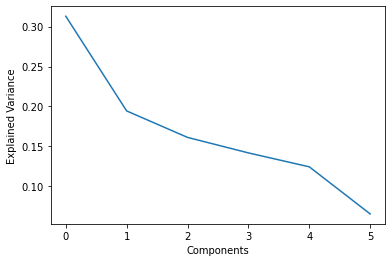

In [39]:
#PCA dimensionality reduction
def pca(week):
    df  = make_features_df(week).drop(['COUNTYFP', 'STNAME'], axis=1)
    df_normalized=(df - df.mean()) / df.std()
    pca = PCA(n_components=df.shape[1])
    pca.fit(df_normalized)

    loadings = pd.DataFrame(pca.components_.T,
    columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
    index=df.columns)
    print(loadings)

    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance')
    plt.xlabel('Components')
    plt.show()


pca(weekly_dates[12])

In [40]:
def function6b(state, week, cases_timestep_df):
    #Selecting and Merging Relevant Potential Feature Data for Predicting Cumulative Vaccination Rate by County 
    #select weekly case data 
    weeks_cases_by_fips = pd.DataFrame(cases_timestep_df.loc[:, :week])

    #select voter data
    votes_by_fips = elections.set_index('county_fips').loc[:, ['per_gop']]

    #select death data 
    death_toll_by_fips = pd.DataFrame(deaths_by_fips[week])

    #select weekly vaxx data
    curr_vaxx_by_fips = pd.DataFrame(vaxx_by_fips[week]) # indexed by state

    #join weekly case, death, and vaxx data with relevant county demographic information 
    relevant_cols = all_data[['STATE', 'STNAME','POPESTIMATE2020', 'COUNTYFP', 'ALWAYS', 'population density']]

    #merging X_train table: 
    all_feat = relevant_cols.merge(votes_by_fips, left_on='COUNTYFP', right_on='county_fips') 
    all_feat = all_feat.merge(death_toll_by_fips, left_on='COUNTYFP', right_on='FIPS')
    all_feat = all_feat.merge(curr_vaxx_by_fips, left_on='STATE', right_on='FIPS', suffixes=('_death', '_vaxx')).drop(columns = 'STATE').rename(columns = {'2021-09-12_death':'death toll', '2021-09-12_vaxx':'curr vaxx'})
    all_feat = all_feat.merge(weeks_cases_by_fips, left_on='COUNTYFP', right_on='FIPS')
    all_feat[all_feat['COUNTYFP'].isin(FIPS_indices)]
    all_feat = all_feat[all_feat['STNAME'] == state]

    X = all_feat.drop(columns = ['STNAME', 'POPESTIMATE2020', 'COUNTYFP', week])
    
    # gets rid of columns containing all zeros
    columns = []
    for column in list(X.columns.values):
        if sum(X[column]) != 0:
            columns.append(column)
    X = X[columns]
    
    y = all_feat[week]


    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.33, random_state=42)
    
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)

    train_rmse_cpc = rmse(y_train, model.predict(X_train))
    test_rmse_cpc = rmse(y_test, model.predict(X_test))

    return state, train_rmse_cpc, test_rmse_cpc

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

In [41]:
def plotting_6b(cases_timestep_df, week):
    # runs function_6a_rmse_model() for all states 
    all_states_6b_rmse_model = []
    for state in states_to_pred:
        all_states_6b_rmse_model += [function6b(state, week, cases_timestep_df)]
    
    # create df with the rmse results from our model
    model_6b_df = pd.DataFrame(all_states_6b_rmse_model).rename({0: 'STNAME', 1: 'Train RMSE', 2: 'Test RMSE'}, axis=1).set_index('STNAME')
    # merge rmse results with abbreviations to help with plotting
    model_6b_df = model_6b_df.merge(state_to_abbrev, on = 'STNAME')
    
    # plot for training rmse
    fig = go.Figure(data=go.Choropleth(
        locations = model_6b_df['abbrev'], # Spatial coordinates
        z = model_6b_df['Train RMSE'], # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Blues',
        colorbar_title = "Train RMSE",
    ))
    if cases_timestep_df.name == "new cases weekly":
        fig.update_layout( 
                title_text = 'Weekly Model RMSEs for Training Data by State during Week of ' + week.strftime("%m/%d/%Y"),
                geo_scope='usa', # limite map scope to USA
        )
    else: 
        fig.update_layout( 
                title_text = 'Daily Model RMSEs for Training Data by State during Week of ' + week.strftime("%m/%d/%Y"),
                geo_scope='usa', # limite map scope to USA
        )
    fig.show()
    
    # plot for test rmse
    fig = go.Figure(data=go.Choropleth(
        locations = model_6b_df['abbrev'], # Spatial coordinates
        z = model_6b_df['Test RMSE'], # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Reds',
        colorbar_title = "Test RMSE",
    ))
    if cases_timestep_df.name == "new cases weekly":
        fig.update_layout(
            title_text = 'Weekly Model RMSEs for Testing Data by State during Week of ' + week.strftime("%m/%d/%Y"),
            geo_scope='usa', # limite map scope to USA
        )
    else:
        fig.update_layout(
            title_text = 'Daily Model RMSEs for Testing Data by State during Week of ' + week.strftime("%m/%d/%Y"),
            geo_scope='usa', # limit map scope to USA
        )
    fig.show()

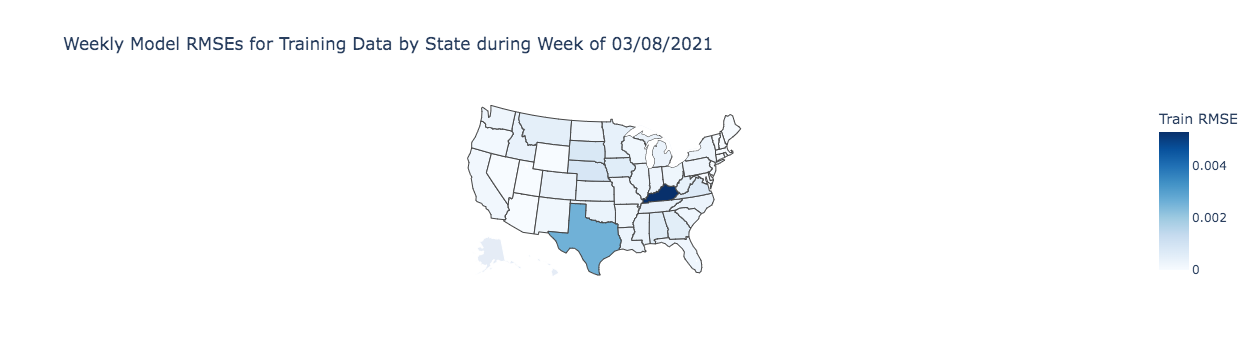

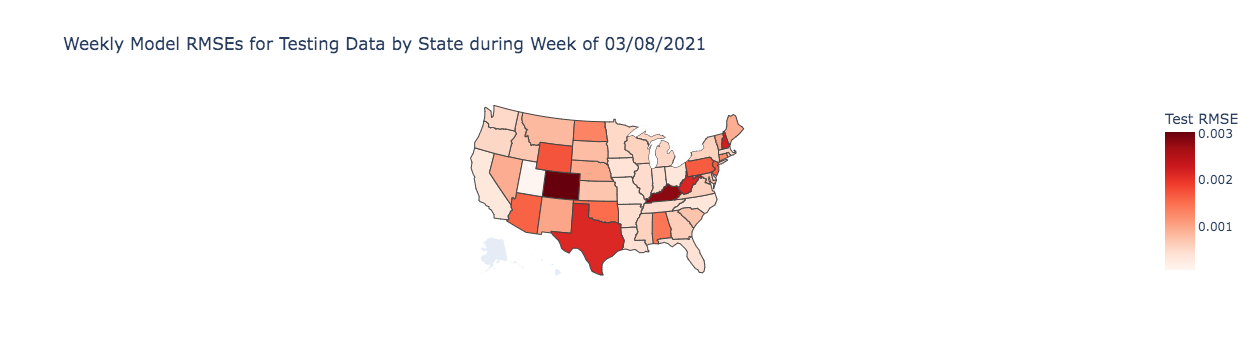

In [42]:
plotting_6b(new_cases_weekly, weekly_dates[12]) # plot rmse for weekly timestep

_The results from this model confirm our initial intuitions about using a weekly temporal split to predict changes in per-capita caseload on the county-level. What we see here is that there is a smaller difference between the RMSE values of the training and testing predictions, indicating that we reduced the variance from the initial baseline model. Moreover, this model overall is more accurate in comparison to the baseline model, as the scale of the RMSE values has been reduced by a factor of ~10. This indicates that both the inclusion of additional features, and using weekly data rather than the previous day's data has resulted in a model that has less overfitting, and higher accuracy._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

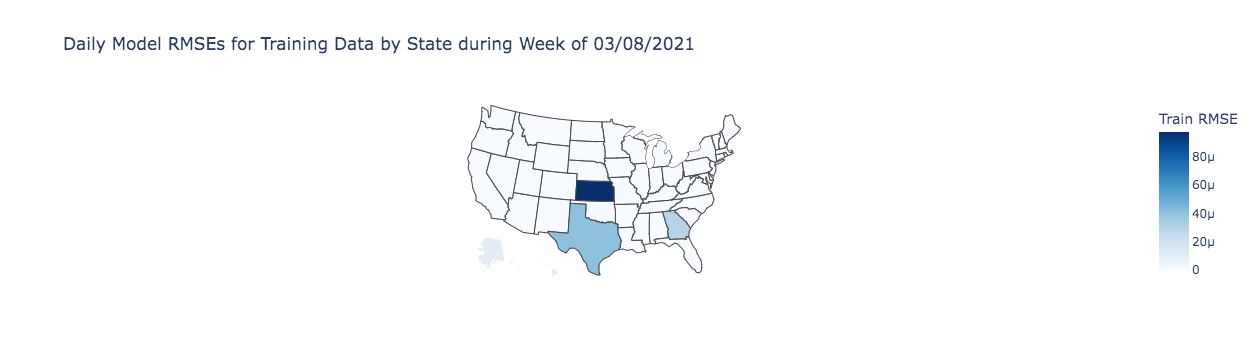

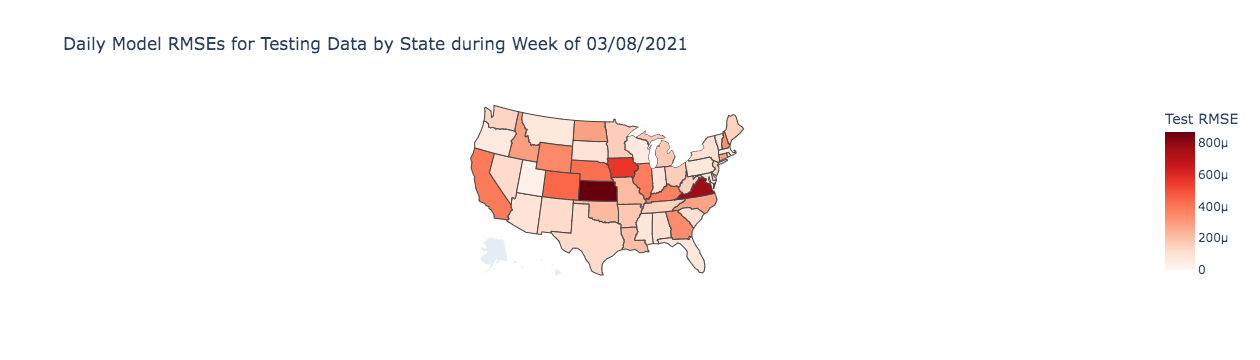

In [47]:
plotting_6b(new_cases, weekly_dates[12]) # plot rmse for daily timestep

_The results of this model show that it achieved a much higher absolute degree of accuracy in comparison to both the baseline model and the model trained on a weekly temporal split, as the range of RMSE values has been reduced by a factor of at least 1000 in both the training and testing RMSEs. However, there is higher degree of variance (in terms of scalar difference) between the training and testin RMSEs -- the training set predictions are more acccurate than the testing set predictions by a factor of 10. However, the absolute values of these RMSEs indicate that in an overall sense, the model still performs significantly better than both the baseline and weekly model._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [48]:
def average_rmse_6b(cases_timestep_df, week):
    # runs function_6a_rmse_model() for all states 
    all_states_6b_rmse_model = []
    for state in states_to_pred:
        all_states_6b_rmse_model += [function6b(state, week, cases_timestep_df)]
    
    # create df with the rmse results from our model
    model_6b_df = pd.DataFrame(all_states_6b_rmse_model).rename({0: 'STNAME', 1: 'Train RMSE', 2: 'Test RMSE'}, axis=1).drop('STNAME', axis=1)
    average_rmse_6b = model_6b_df.apply(np.average, axis=0)
    return average_rmse_6b['Test RMSE']

daily_model_avg_rmses = []
weekly_model_avg_rmses = []
for week in weekly_dates:
    daily_model_avg_rmses += [average_rmse_6b(new_cases, week)]
    weekly_model_avg_rmses += [average_rmse_6b(new_cases_weekly, week)]

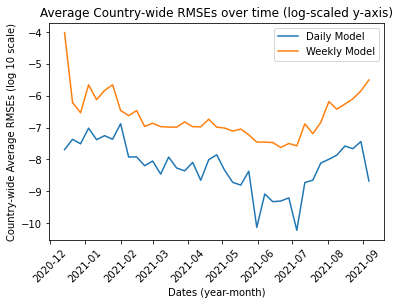

In [49]:
plt.plot(weekly_dates, np.log(daily_model_avg_rmses), label = 'Daily Model')
plt.plot(weekly_dates, np.log(weekly_model_avg_rmses), label = 'Weekly Model')
plt.xticks(rotation = 45)
plt.title('Average Country-wide RMSEs over time (log-scaled y-axis)')
plt.ylabel('Country-wide Average RMSEs (log 10 scale)')
plt.xlabel('Dates (year-month)')
plt.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [ ]:
...

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [43]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [44]:
# Save your notebook first, then run this cell to export your submission.
grader.export()